## Example Notebook of comparing PTMCMC and dynesty in MAPS in recovering square-root spherical harmonics parameters with narrow and broad priors
First let's import the necessary packages

In [1]:
# If you are just testing this package without installing, you can add the package to the path
import sys
sys.path.insert(0,'../..')
import maps
print('Using maps from', maps.__file__)

Using maps from /Users/kushagran.nag/IPTA_GWB/anisotropy/MAPS/MAPS/docs/Bayesian_inference/../../maps/__init__.py


In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from maps import anis_pta as ap
from maps import utils

import numpy.random as rn
from enterprise.signals import anis_coefficients as ac
import bilby
import pandas as pd
import pickle, corner
from la_forge import core, diagnostics

Optional mpi4py package is not installed.  MPI support is not available.


/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


## Simulate data

In MAPS, we consider amplitude scaled pulsar pairs cross-correlations ($\rho$) as our data. This can be modelled by the detector Overlap Reduction Function (ORF) given as $\Gamma = A (R \cdot P)$. Where, $A$ is the amplitude correction parameter.

In this example, to simulate $\Gamma$, first we define 67 pulsars uniformly distributed accross the sky, $nside$ defining the no. of pixel tessellation of the healpix sky (and hence no. of pixels in the sky), $l_{max}$ defining the maximum angular resolution of the sky to use for spherical harmonics representation.

In [3]:
### Create a random draw generator with a seed
rng = rn.default_rng(seed=316)

In [4]:
npsrs = 67
nside = 8
l_max = 6
nblm = int((l_max/2+1)**2)

ncc = int(npsrs*(npsrs-1)/2)

print(f"Using {npsrs} pulsars with {ncc} pairs.")
print(f"Using {l_max} lmax with {nblm} blm parameters.")

Using 67 pulsars with 2211 pairs.
Using 6 lmax with 16 blm parameters.


In [5]:
#Draw random uniform positions for pulsars in PTA
psrs_phi = rng.uniform(low = 0, high = 2 * np.pi, size = npsrs)
psrs_theta = np.arccos(1 - 2 * rng.uniform(0, 1, size = npsrs))

Now, initiate a PTA object without correlation values to gain access to some useful functions. Note that we can set data afterwards. Here, we define the basis in which we search for anisotropy. In this example, we use 'sqrt_power_basis' which is the square-root spherical harmonics basis.

Here, we define 2 different pta object cause we will run inference for both using broad and using narrow priors. The ptmcmc sampler is set within the anis_pta object and hence we require them to be separate. Note that further below we will do the same for bilby.

In [6]:
### For ptmcmc with narrow priors
pta_ptmcmc_narrow = ap.anis_pta(psrs_theta, psrs_phi, nside = nside, l_max = l_max, mode = 'sqrt_power_basis')

### For ptmcmc with broad priors
pta_ptmcmc_broad = ap.anis_pta(psrs_theta, psrs_phi, nside = nside, l_max = l_max, mode = 'sqrt_power_basis')

/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/enterprise/signals/anis_coefficients.py:194: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  h = hp.alm2map(alm, nside, maxl, verbose=False)


Some of the important functions that this sets up are: the response matrix $R$ of shape ($N_{cross-correlations} \times N_{pix}$), real-valued spherical harmonics $Y_{lm}(\theta, \phi)$ of shape ($N_{clm} \times N_{pix}$) and hence $\Gamma_{lm} = Y_{lm} \cdot R^{T}$ of shape ($N_{clm} \times N_{cross-correlations}$).

### Inject anisotropy

In this example, we can create injections using $2$ methods.

1. Adding a hotspot to an isotropic background: 
       We generate this as individual pixel powers. For an isotropic background, we can supply a pixel vector of all 1, meaning even power throughout the sky. On top of this, select a circular area on the sky at ($\theta$, $\phi$) for which we increase the power. We then combine this simulated map of shape ($N_{pix}$) with $R$ to create the injected data. 

2. With $b_{lm}$ values: 
       We generate random $b_{lm}$ values with $b_{00}=1$. Then we convert $b_{lm}$'s to $c_{lm}$'s and finally combine it with $\Gamma_{lm}$ to create the injected data.

Note that while MAPS does support pair covariance, this example will not use it.

Here, we use method $1$ and use a handy function in utils: ``` utils.inject_anisotropy(pta, method, **arg) ```. Here, all **arg are optional. This function creates the <span style="color:blue">injection</span> attributes of anis_pta instance/object. <span style="color:blue">pta.injected_rho</span>, <span style="color:blue">pta.injected_sig</span>, and <span style="color:blue">pta.injected_pair_cov</span> contains the injected cross_correlations ($\rho$) data, $1-d$ uncertainties on $\rho$, and diagonal pair-covariance matrix (None if not supplied) respectively. 

* With method 1, <span style="color:blue">pta.injected_power</span>, and <span style="color:blue">pta.injected_Cl</span> contains an array of injected pixel power, and angular power spectrum respectively which is very handy for post processing.

* With method 2, <span style="color:blue">pta.injected_blms</span>, <span style="color:blue">pta.injected_power</span>, and <span style="color:blue">pta.injected_Cl</span> contains an array of injected $b_{lm}$'s, pixel power, and angular power spectrum respectively which is very handy for post processing.

In [7]:
### One can add random noise using add_rand_noise=True 
### which adds gaussian noise scaled by sim_sig

### For method 1:
#utils.inject_anisotropy(pta, method='pixel', sim_log10_A2=0.0, sim_power=50, sim_theta=np.pi/3, sim_phi=np.pi/2, lonlat=False, 
#                        sim_pixel_radius=10, sim_sig=0.1, pair_cov=False, return_vals=False, add_rand_noise=False)

### For method 2:
### Note that we can supply a list of blm value to inject using sim_blms.
### If it's None then the values are randomly generated internally with seed=seed (optional).
### For ptmcmc with narrow priros
utils.inject_anisotropy(pta_ptmcmc_narrow, method='sqrt_power_basis', bl0_min=-3.0, bl0_max=3.0, 
                        blm_amp_min=1.0, blm_amp_max=3.0, 
                        blm_phase_min=1.5707963267948966, blm_phase_max=4.71238898038469, seed=316)

### For ptmcmc with broad priros with same values using seed
utils.inject_anisotropy(pta_ptmcmc_broad, method='sqrt_power_basis', bl0_min=-3.0, bl0_max=3.0, 
                        blm_amp_min=1.0, blm_amp_max=3.0, 
                        blm_phase_min=1.5707963267948966, blm_phase_max=4.71238898038469, seed=316)

##### Let's look at the injection in the skymap and ORF representation.

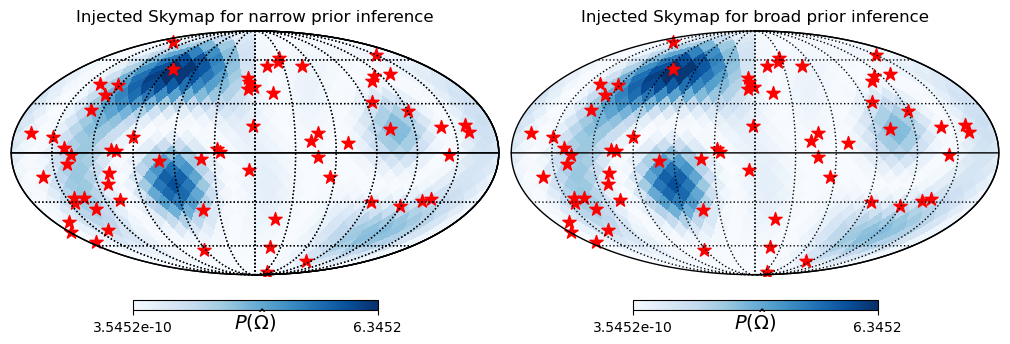

In [8]:
# Plot the injection
plt.figure(figsize=(10,5))

hp.mollview(pta_ptmcmc_narrow.injected_power, sub=121, title = 'Injected Skymap for narrow prior inference',cmap='Blues', 
            unit='$P(\hat\Omega)$', rot=180)
hp.graticule()

hp.mollview(pta_ptmcmc_broad.injected_power, sub=122, title = 'Injected Skymap for broad prior inference',cmap='Blues', 
            unit='$P(\hat\Omega)$', rot=180)
hp.graticule()

hp.projscatter(pta_ptmcmc_narrow.psrs_theta, pta_ptmcmc_narrow.psrs_phi, color = 'red', marker = '*', s = 100)
plt.show()

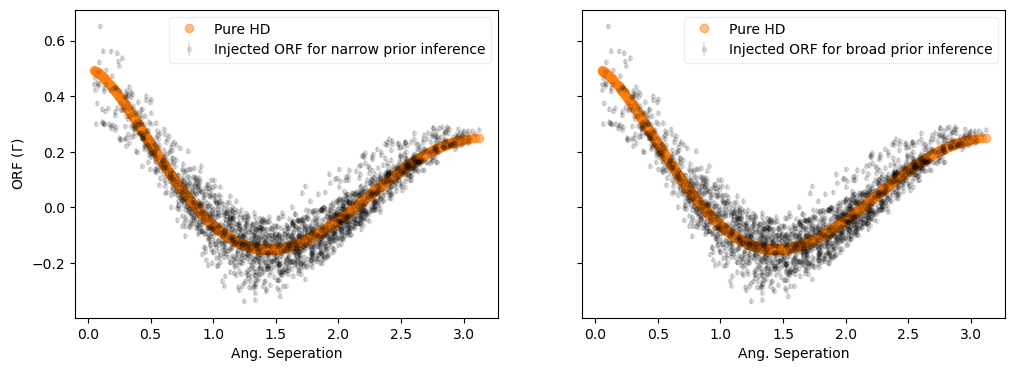

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)

ax[0].errorbar(pta_ptmcmc_narrow.xi, pta_ptmcmc_narrow.injected_rho, pta_ptmcmc_narrow.injected_sig, marker='.', color='black', 
               alpha=0.1, ls='', label='Injected ORF for narrow prior inference')
ax[0].plot(pta_ptmcmc_narrow.xi, pta_ptmcmc_narrow.get_pure_HD(), color='tab:orange', alpha=0.5, marker='o', ls='', label='Pure HD')
ax[0].set_xlabel('Ang. Seperation')
ax[0].set_ylabel(r'ORF ($\Gamma$)')
ax[0].legend(framealpha=0.3)


ax[1].errorbar(pta_ptmcmc_broad.xi, pta_ptmcmc_broad.injected_rho, pta_ptmcmc_broad.injected_sig, marker='.', color='black', 
               alpha=0.1, ls='', label='Injected ORF for broad prior inference')
ax[1].plot(pta_ptmcmc_broad.xi, pta_ptmcmc_broad.get_pure_HD(), color='tab:orange', alpha=0.5, marker='o', ls='', label='Pure HD')
ax[1].set_xlabel('Ang. Seperation')
ax[1].legend(framealpha=0.3)


plt.show()

## Now let's run our bayesian inference

First we supply our anis_pta object, the cross-correlation and uncertainty data we generated.

In [10]:
### Note that here pta.injected_pair_cov is None as we didn't supply it while creating the data

### For ptmcmc with narrow prior
pta_ptmcmc_narrow.set_data(rho=pta_ptmcmc_narrow.injected_rho, sig=pta_ptmcmc_narrow.injected_sig, 
                           os=1, covariance=pta_ptmcmc_narrow.injected_pair_cov)

### For ptmcmc with broad prior
pta_ptmcmc_broad.set_data(rho=pta_ptmcmc_broad.injected_rho, sig=pta_ptmcmc_broad.injected_sig, 
                           os=1, covariance=pta_ptmcmc_broad.injected_pair_cov)

### Using PTMCMC sampler

First, set an output directory for ptmcmc. Then setup the ptmcmc sampler using the ```set_ptmcmc``` function.

* The priors here are set internally. The type of priors can be specified by the 'prior_form' argument. Currently, it accepts 'Uniform', 'Normal' or 'TruncNormal'. Also, one can pass the min, max prior boundaries and mu, sigma when using 'Normal' or 'TruncNormal'. One can access these priors with <span style="color:blue">priors</span> attribute of anis_pta object. Also, note that we can pickle the anis_pta object using the 'save_anis_pta' flag to the outdir for better post-processing.

* We will run inferences using narrow and broad priors and look at the recovery

In [11]:
### set an output directory for ptmcmc
ptmcmc_outdir_broad = './bayes_data/sqrt_basis/ptmcmc_broad/'
ptmcmc_outdir_narrow = './bayes_data/sqrt_basis/ptmcmc_narrow/'

In [12]:
### Setup the ptmcmc sampler with broad and narrow priors.
ptmcmc_sampler_narrow = pta_ptmcmc_narrow.set_ptmcmc(prior_form='Uniform', log10_A2_prior_min=-2, log10_A2_prior_max=2,
                                                     bl0_prior_min=-5, bl0_prior_max=5, 
                                                     blm_amp_prior_min=0, blm_amp_prior_max=5, 
                                                     blm_phase_prior_min=0, blm_phase_prior_max=6.283185307179586,
                                                     outdir=ptmcmc_outdir_narrow, resume=True, save_anis_pta=True)

ptmcmc_sampler_broad = pta_ptmcmc_broad.set_ptmcmc(prior_form='Uniform', log10_A2_prior_min=-2, log10_A2_prior_max=2,
                                                   bl0_prior_min=-50, bl0_prior_max=50, 
                                                   blm_amp_prior_min=0, blm_amp_prior_max=50, 
                                                   blm_phase_prior_min=0, blm_phase_prior_max=6.283185307179586,
                                                   outdir=ptmcmc_outdir_broad, resume=True, save_anis_pta=True)

In [13]:
# sampler for N steps
N = int(1e6)
x0_narrow = np.array([p1.sample() for p1 in pta_ptmcmc_narrow.priors])
x0_broad = np.array([p2.sample() for p2 in pta_ptmcmc_broad.priors])

In [15]:
### let's sample with narrow priors
ptmcmc_sampler_narrow.sample(x0_narrow, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 0.00 percent (0.00 percent of new work) in 0.001905 s Acceptance rate = 0

/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/enterprise/signals/parameter.py:70: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 1.00 percent (1.00 percent of new work) in 5.182987 s Acceptance rate = 0.105289Adding DE jump with weight 50
Finished 100.00 percent (100.00 percent of new work) in 491.432544 s Acceptance rate = 0.290367
Run Complete


In [17]:
### let's sample with broad priors
ptmcmc_sampler_broad.sample(x0_broad, N, SCAMweight=30, AMweight=15, DEweight=50)

Finished 1.00 percent (1.00 percent of new work) in 3.652429 s Acceptance rate = 0.096122Adding DE jump with weight 50
Finished 100.00 percent (100.00 percent of new work) in 372.768457 s Acceptance rate = 0.131151
Run Complete


### Using Dynesty Sampler wrapped in bilby

Look at bilby documentation for looking at the samplers compatible with [Bilby](https://bilby-dev.github.io/bilby/api/bilby.core.sampler.html). Note that with defining a custom bilby likelihood (like we have done for MAPS), bilby internally converts the structure of likelihood according to the sampler we use to perform inference. However, pymc sampler requires a symbolic definition of the likelihood and will throw errors if we use it. Make sure that you install bilby and the samplers in it which you wish to use.

* Here we initialize the 2 seperate pta object (for narrow and broad prior inference) again for bilby just to not have any overlap with the ptmcmc setup that we did above.

* Again first we set an output directory for bilby (dynesty). 

* Then instantiate the bilby likelihood class ```set_bilby(pta, **args)``` which lives in anis_pta.py framework not in anis_pta class. Here, we name the instance as bilby_bayes. Note that since we are working and comparing inference with different priors, we need to call the likelihood seperately for each case.

* Note we need to pass it the anis_pta object. And here again the uniform pirors for our parameters are set internally according to bilby compatibility where one can pass the min and max prior boundaries. One can access these priors with <span style="color:blue">priors</span> attribute of anis_pta.set_bilby instance. Also, note that we can pickle the anis_pta object to the outdir for better post-processing.

* Finally, we use the ```bilby.core.sampler.run_sampler``` primary interface for parameter estimation. Here, we need to pass in the bilby likelihood instance (here we name it bilby_bayes), the priors (an attribute of bilby_bayes), sampler's name, parameters for the sampler (like nlive, dlogz for dynesty), outdir and a label. Note that different samplers might require different/more parameters.

In [18]:
### For bilby with narrow priors
pta_bb_narrow = ap.anis_pta(psrs_theta, psrs_phi, nside = nside, l_max = l_max, mode = 'sqrt_power_basis')

### For bilby with broad priors
pta_bb_broad = ap.anis_pta(psrs_theta, psrs_phi, nside = nside, l_max = l_max, mode = 'sqrt_power_basis')

/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/enterprise/signals/anis_coefficients.py:194: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  h = hp.alm2map(alm, nside, maxl, verbose=False)


In [23]:
### Now set data
### Note that here pta.injected_pair_cov is None as we didn't supply it while creating the data

### For ptmcmc with narrow prior
pta_bb_narrow.set_data(rho=pta_ptmcmc_narrow.injected_rho, sig=pta_ptmcmc_narrow.injected_sig, 
                       os=1, covariance=pta_ptmcmc_narrow.injected_pair_cov)

### For ptmcmc with broad prior
pta_bb_broad.set_data(rho=pta_ptmcmc_broad.injected_rho, sig=pta_ptmcmc_broad.injected_sig, 
                      os=1, covariance=pta_ptmcmc_broad.injected_pair_cov)

In [24]:
### set an output directory for bilby 
bb_outdir_narrow = './bayes_data/sqrt_basis/bilby_dynesty_narrow/'
bb_outdir_broad = './bayes_data/sqrt_basis/bilby_dynesty_broad/'

In [25]:
### Instantiate the custom bilby likelihood
### For inference with narrow priors
bilby_bayes_narrow = ap.set_bilby(pta_bb_narrow, log10_A2_prior_min=-2, log10_A2_prior_max=2, 
                                  bl0_prior_min=-5, bl0_prior_max=5, 
                                  blm_amp_prior_min=0, blm_amp_prior_max=5, 
                                  blm_phase_prior_min=0, blm_phase_prior_max=6.283185307179586,
                                  outdir=bb_outdir_narrow, save_anis_pta=True)

### For inference with broad priors
bilby_bayes_broad = ap.set_bilby(pta_bb_broad, log10_A2_prior_min=-2, log10_A2_prior_max=2, 
                                 bl0_prior_min=-50, bl0_prior_max=50, 
                                 blm_amp_prior_min=0, blm_amp_prior_max=50, 
                                 blm_phase_prior_min=0, blm_phase_prior_max=6.283185307179586, 
                                 outdir=bb_outdir_broad, save_anis_pta=True)

In [26]:
### Launch sampler
result_narrow = bilby.core.sampler.run_sampler(
    bilby_bayes_narrow,
    bilby_bayes_narrow.priors,
    sampler='dynesty',
    nlive=500, 
    sample='rwalk',
    dlogz=0.1, 
    outdir=bb_outdir_narrow,
    label="sqr_basis_narrow_priors"
)

23:41 bilby INFO    : Running for label 'sqr_basis_narrow_priors', output will be saved to './bayes_data/linear_basis/bilby_dynesty_narrow/'
23:41 bilby INFO    : Analysis priors:
23:41 bilby INFO    : log10_A2=Uniform(minimum=-2, maximum=2, name='log10_A2', latex_label='log10_A2', unit=None, boundary=None)
23:41 bilby INFO    : b_10=Uniform(minimum=-5, maximum=5, name='b_10', latex_label='b_10', unit=None, boundary=None)
23:41 bilby INFO    : b_11_amp=Uniform(minimum=0, maximum=5, name='b_11_amp', latex_label='b_11_amp', unit=None, boundary=None)
23:41 bilby INFO    : b_11_phase=Uniform(minimum=0, maximum=6.283185307179586, name='b_11_phase', latex_label='b_11_phase', unit=None, boundary=None)
23:41 bilby INFO    : b_20=Uniform(minimum=-5, maximum=5, name='b_20', latex_label='b_20', unit=None, boundary=None)
23:41 bilby INFO    : b_21_amp=Uniform(minimum=0, maximum=5, name='b_21_amp', latex_label='b_21_amp', unit=None, boundary=None)
23:41 bilby INFO    : b_21_phase=Uniform(minimum=0,

39862it [10:00, 70.91it/s, bound:1803 nc:  1 ncall:1.1e+06 eff:3.6% logz=8071.66+/-0.38 dlogz:0.000205>0.1] 

23:52 bilby INFO    : Written checkpoint file ./bayes_data/linear_basis/bilby_dynesty_narrow//sqr_basis_narrow_priors_resume.pickle
/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/dynesty/plotting.py:252: RuntimeWarning: overflow encountered in exp
  np.exp(logwt), logz if logplot else np.exp(logz)
/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/dynesty/plotting.py:282: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
23:52 bilby WARNING : Axis limits cannot be NaN or Inf
23:52 bilby WARNING : Failed to create dynesty run plot at checkpoint


39862it [10:20, 64.20it/s, bound:1803 nc:  1 ncall:1.1e+06 eff:3.6% logz=8071.66+/-0.38 dlogz:0.000205>0.1]

23:52 bilby INFO    : Rejection sampling nested samples to obtain 3412 posterior samples
23:52 bilby INFO    : Sampling time: 0:10:20.912764


23:52 bilby INFO    : Summary of results:
nsamples: 3412
ln_noise_evidence:    nan
ln_evidence: 8071.662 +/-  0.424
ln_bayes_factor:    nan +/-  0.424



In [27]:
### Launch sampler
result_broad = bilby.core.sampler.run_sampler(
    bilby_bayes_broad,
    bilby_bayes_broad.priors,
    sampler='dynesty',
    nlive=500, 
    sample='rwalk',
    dlogz=0.1, 
    outdir=bb_outdir_broad,
    label="sqr_basis_broad_priors"
)

23:52 bilby INFO    : Running for label 'sqr_basis_broad_priors', output will be saved to './bayes_data/linear_basis/bilby_dynesty_broad/'
23:52 bilby INFO    : Analysis priors:
23:52 bilby INFO    : log10_A2=Uniform(minimum=-2, maximum=2, name='log10_A2', latex_label='log10_A2', unit=None, boundary=None)
23:52 bilby INFO    : b_10=Uniform(minimum=-50, maximum=50, name='b_10', latex_label='b_10', unit=None, boundary=None)
23:52 bilby INFO    : b_11_amp=Uniform(minimum=0, maximum=50, name='b_11_amp', latex_label='b_11_amp', unit=None, boundary=None)
23:52 bilby INFO    : b_11_phase=Uniform(minimum=0, maximum=6.283185307179586, name='b_11_phase', latex_label='b_11_phase', unit=None, boundary=None)
23:52 bilby INFO    : b_20=Uniform(minimum=-50, maximum=50, name='b_20', latex_label='b_20', unit=None, boundary=None)
23:52 bilby INFO    : b_21_amp=Uniform(minimum=0, maximum=50, name='b_21_amp', latex_label='b_21_amp', unit=None, boundary=None)
23:52 bilby INFO    : b_21_phase=Uniform(minimu

38560it [10:43, 59.96it/s, bound:1890 nc: 33 ncall:1.2e+06 eff:3.3% logz=7966.86+/-0.40 dlogz:60.3>0.1]     

00:03 bilby INFO    : Written checkpoint file ./bayes_data/linear_basis/bilby_dynesty_broad//sqr_basis_broad_priors_resume.pickle
00:03 bilby WARNING : The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.
00:03 bilby WARNING : Failed to create dynesty unit state plot at checkpoint
/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/dynesty/plotting.py:252: RuntimeWarning: overflow encountered in exp
  np.exp(logwt), logz if logplot else np.exp(logz)
/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/dynesty/plotting.py:282: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
00:03 bilby WARNIN

52173it [14:44, 67.79it/s, bound:2593 nc:  1 ncall:1.6e+06 eff:3.3% logz=8046.53+/-0.44 dlogz:0.000203>0.1]

00:07 bilby INFO    : Written checkpoint file ./bayes_data/linear_basis/bilby_dynesty_broad//sqr_basis_broad_priors_resume.pickle
/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/dynesty/plotting.py:252: RuntimeWarning: overflow encountered in exp
  np.exp(logwt), logz if logplot else np.exp(logz)
/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/dynesty/plotting.py:282: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
00:07 bilby WARNING : Axis limits cannot be NaN or Inf
00:07 bilby WARNING : Failed to create dynesty run plot at checkpoint


52173it [15:19, 56.77it/s, bound:2593 nc:  1 ncall:1.6e+06 eff:3.3% logz=8046.53+/-0.44 dlogz:0.000203>0.1]

00:07 bilby INFO    : Rejection sampling nested samples to obtain 3584 posterior samples
00:07 bilby INFO    : Sampling time: 0:15:19.010112


00:07 bilby INFO    : Summary of results:
nsamples: 3584
ln_noise_evidence:    nan
ln_evidence: 8046.534 +/-  0.514
ln_bayes_factor:    nan +/-  0.514



## Post-processing

#### 1. First load the data

In [58]:
### For ptmcmc runs
ptmcmc_core_narrow = core.Core(chaindir=ptmcmc_outdir_narrow, burn=0.25)
ptmcmc_core_broad = core.Core(chaindir=ptmcmc_outdir_broad, burn=0.55)

### For bilby runs if one wants to explicitly load the data
### bb_data = bilby.result.read_in_result('./bayes_data/sqrt_basis/bilby_dynesty_narrow/sqr_basis_narrow_priors_result.json')
### emcee takes a lot of space

### If one wants to load the pickled anis_pta object
### with open(ptmcmc_outdir+'anis_pta.pickle', 'rb') as f:
###    pta = pickle.load(f)

#### 2. Let's look at the trace-plots

##### For PTMCMC

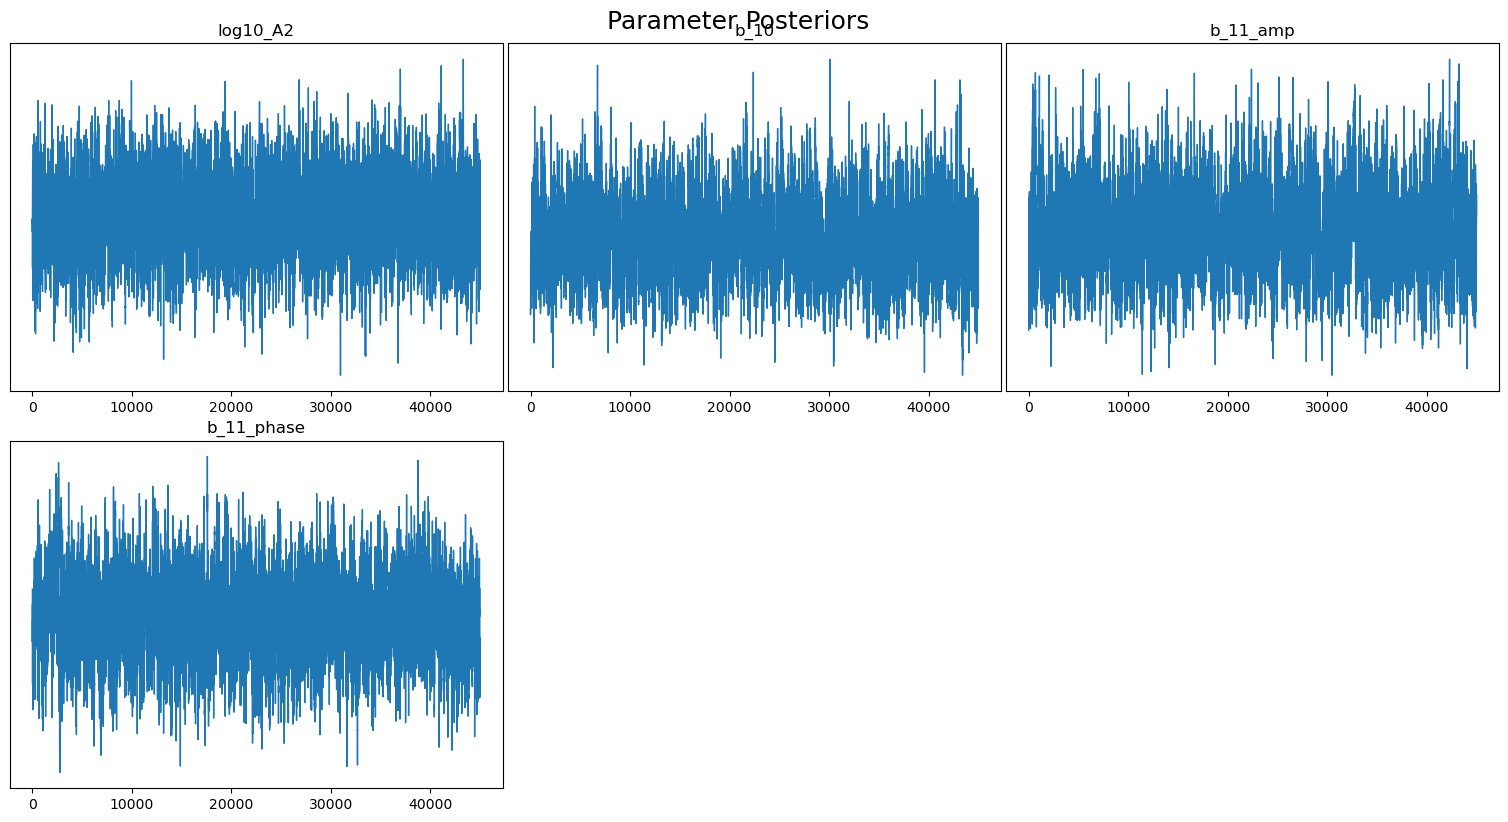

In [59]:
diagnostics.plot_chains(ptmcmc_core_broad, hist=False, pars=pta_ptmcmc_broad.param_names[:4])

##### For Dynesty 

In [35]:
### We will use the dynesty plotting function for this
### First we load the dynesty sampler which was saved after the run (or during every checkpoint)
### We should use this only for diagnostic purposes
with open('./bayes_data/sqrt_basis/bilby_dynesty_narrow/sqr_basis_narrow_priors_resume.pickle', 'rb') as f:
    dynesty_sampler_narrow = pickle.load(f)

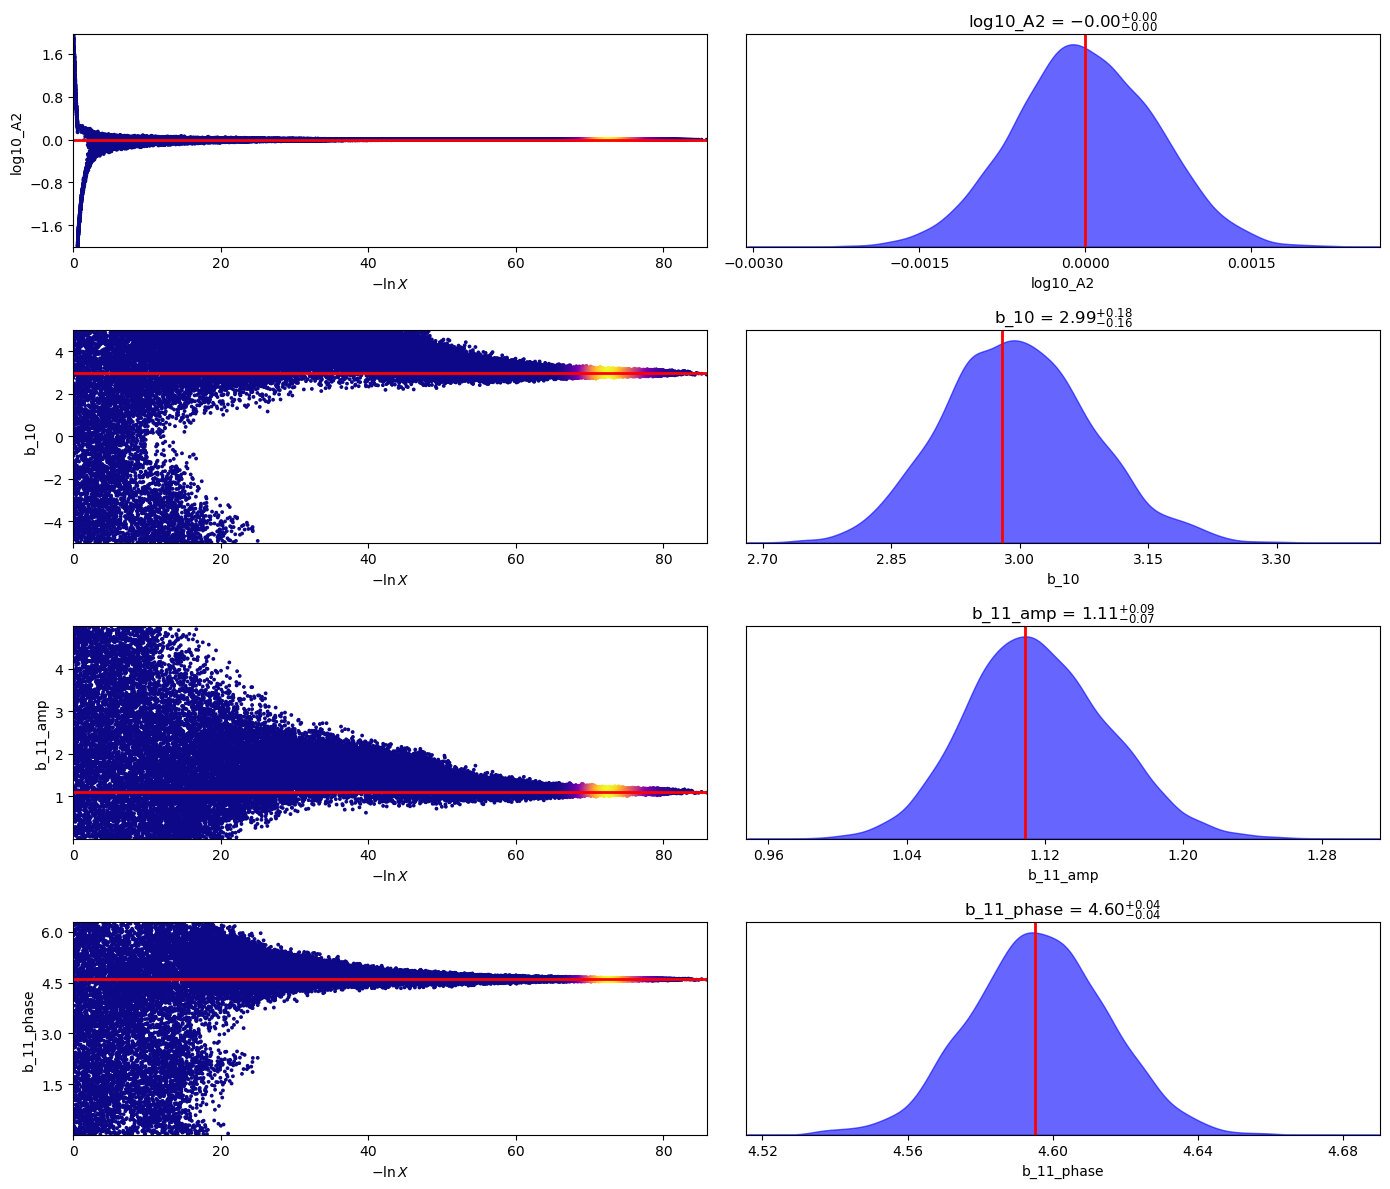

In [48]:
from dynesty import plotting as dyplot

# plotting the narrow prior run
fig, axes = dyplot.traceplot(dynesty_sampler_narrow.results, truths=[0.0, *pta_ptmcmc_narrow.injected_blms[1:]], show_titles=True, trace_cmap='plasma',
                             labels=result_narrow.parameter_labels, quantiles=None, dims=[0, 1, 2, 3],
                             fig=plt.subplots(4, 2, figsize=(14, 12)))
fig.tight_layout()

#### 3. Now let's look at the corner plots

##### For PTMCMC

In [60]:
### Get array of ptmcmc samples to display a corner plot
ptmcmc_corner_params_narrow = ptmcmc_core_narrow.get_param(pta_ptmcmc_narrow.param_names)
ptmcmc_corner_params_broad = ptmcmc_core_broad.get_param(pta_ptmcmc_broad.param_names)

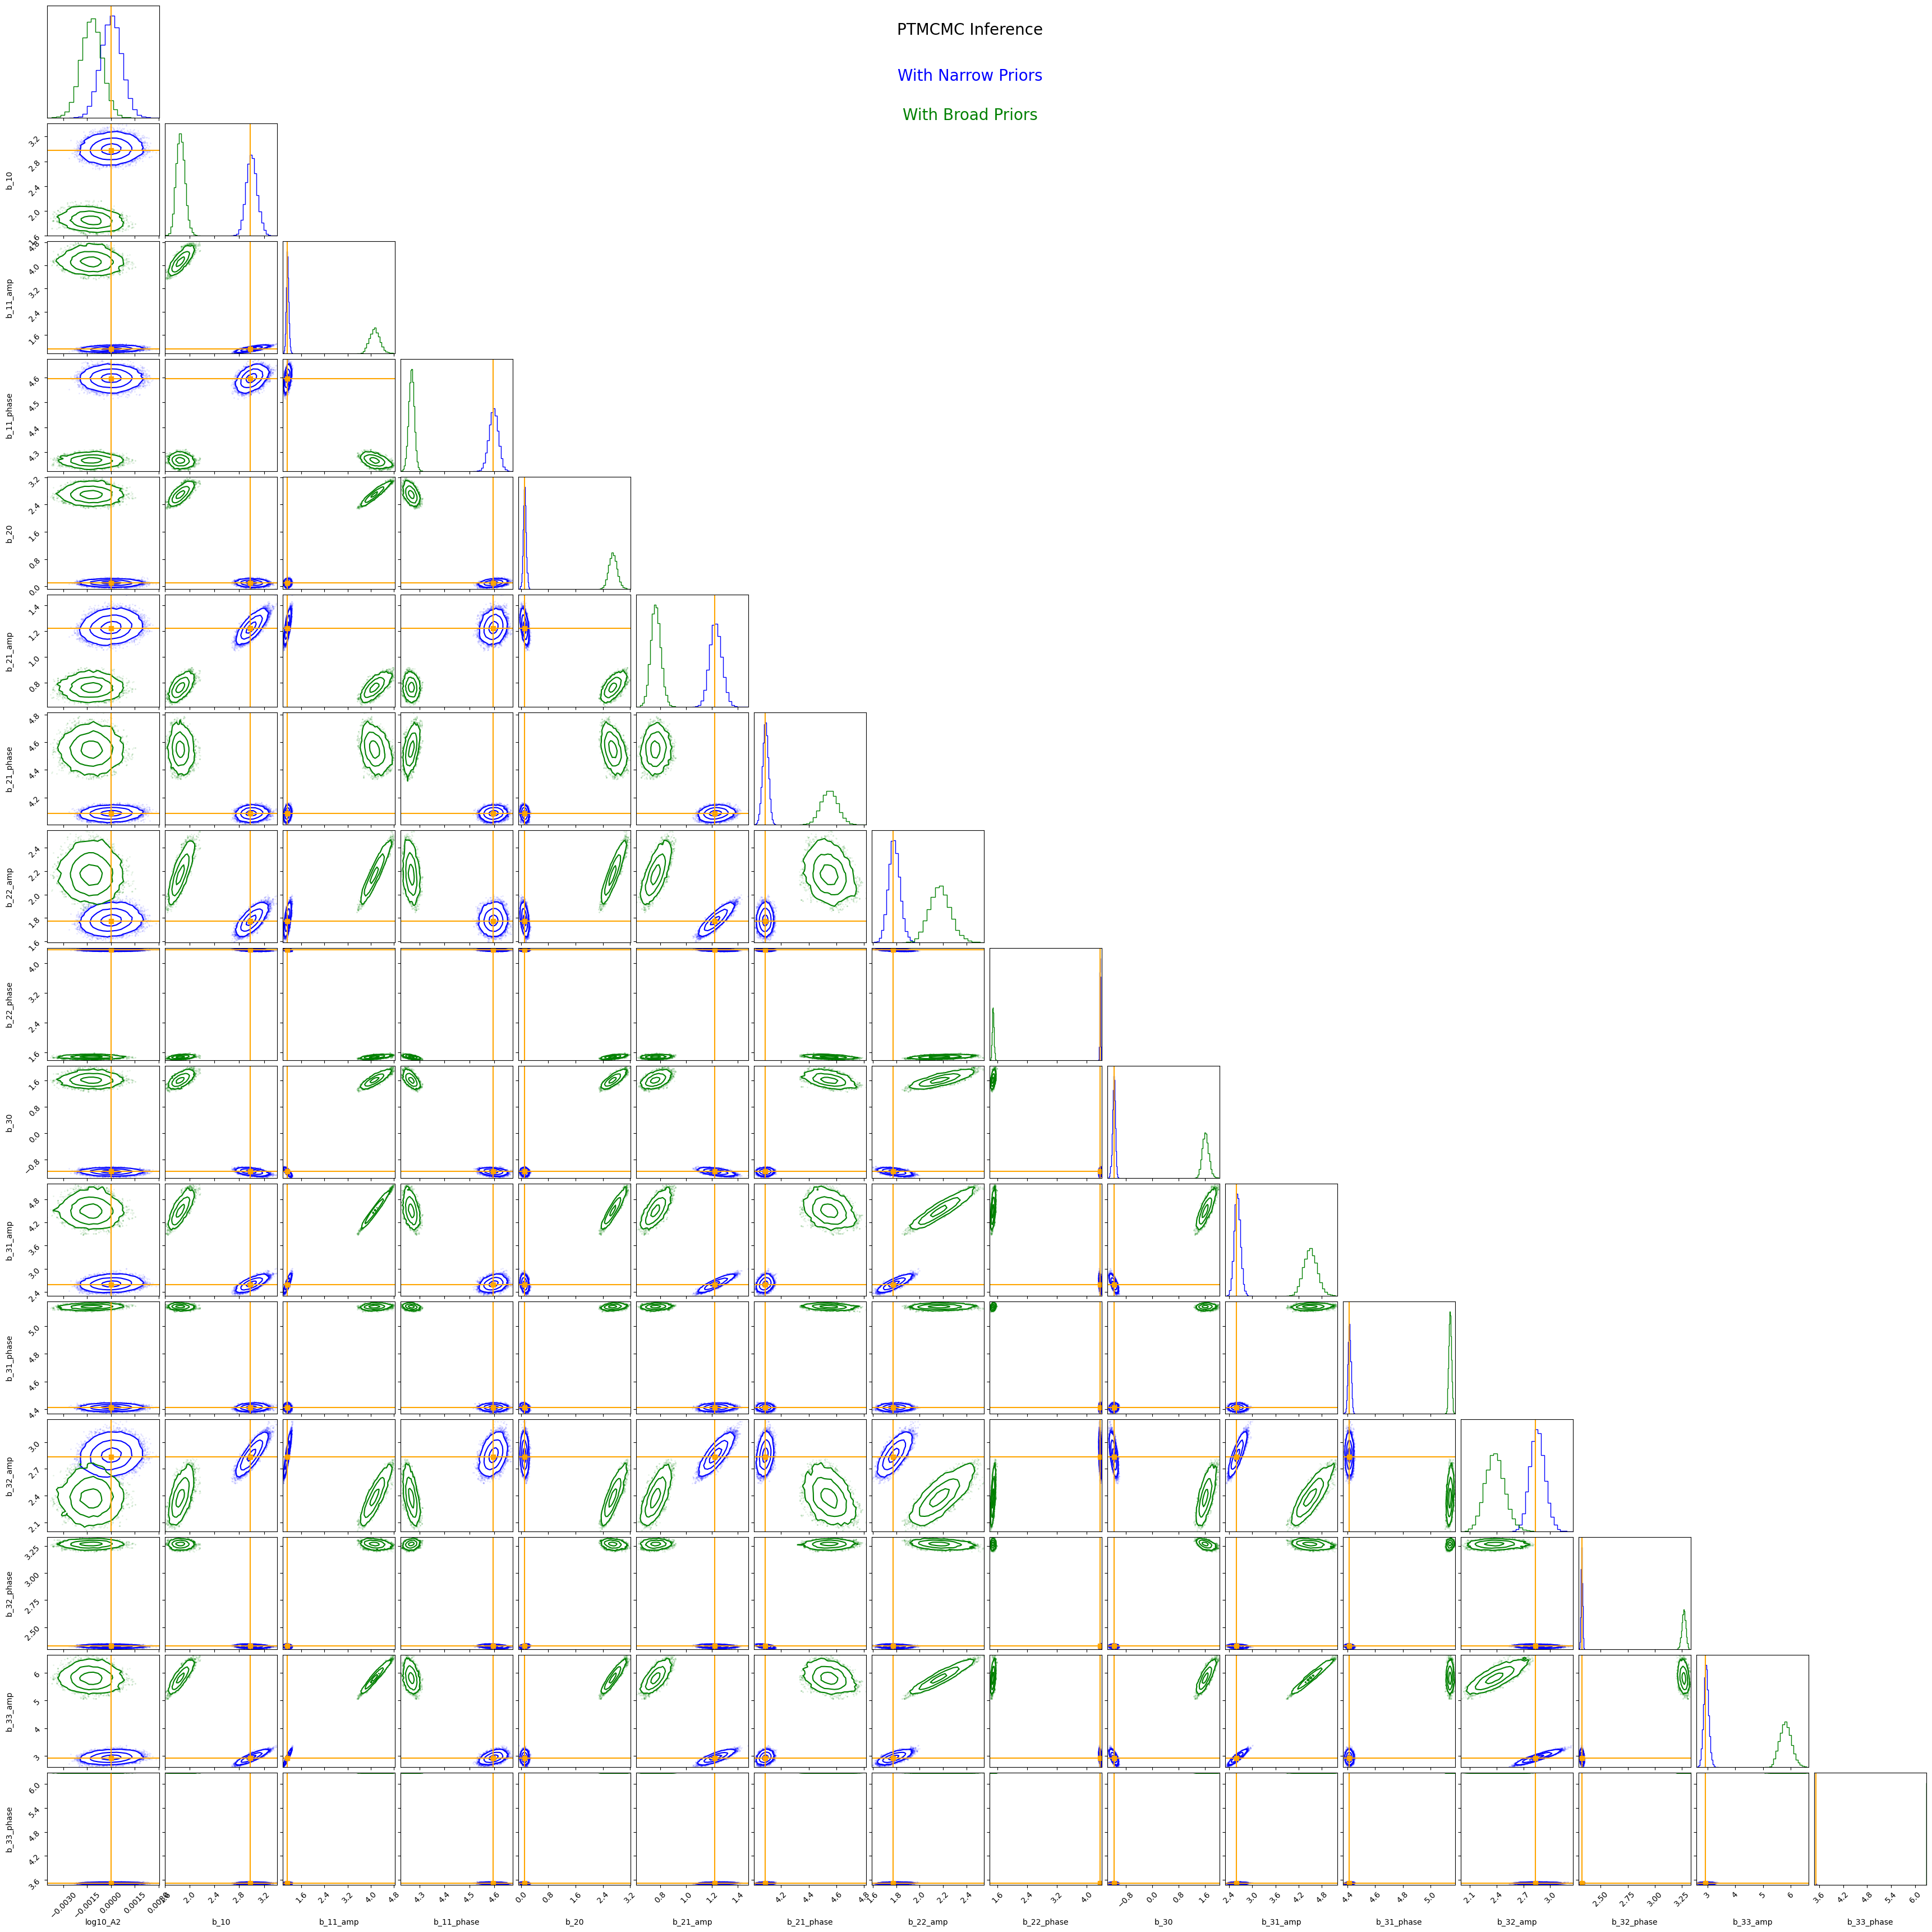

In [61]:
fig2 = corner.corner(ptmcmc_corner_params_narrow, 
                     plot_datapoints=True, fill_contours=False, plot_density=False, 
                     color='blue', levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), 
                     labels=pta_ptmcmc_narrow.param_names, title_quantiles=[0.16, 0.5, 0.84], 
                     hist_kwargs=dict(density=True, histtype="step"))

corner.corner(ptmcmc_corner_params_broad, fig=fig2, 
              plot_datapoints=True, fill_contours=False, plot_density=False, 
              color='green', levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), 
              labels=pta_ptmcmc_broad.param_names, title_quantiles=[0.16, 0.5, 0.84], 
              hist_kwargs=dict(density=True, histtype="step"), 
              truths=[0.0, *pta_ptmcmc_broad.injected_blms[1:]], truth_color='orange')


fig2.suptitle('PTMCMC Inference', fontsize=20)
fig2.text(0.5, 0.95, "With Narrow Priors", color='blue', ha="center", fontsize=20)
fig2.text(0.5, 0.93, "With Broad Priors", color='green', ha="center", fontsize=20)


plt.show()

#### Here we see that only the narrow priors could recover the blm parameters!!

##### For Bilby-Dynesty

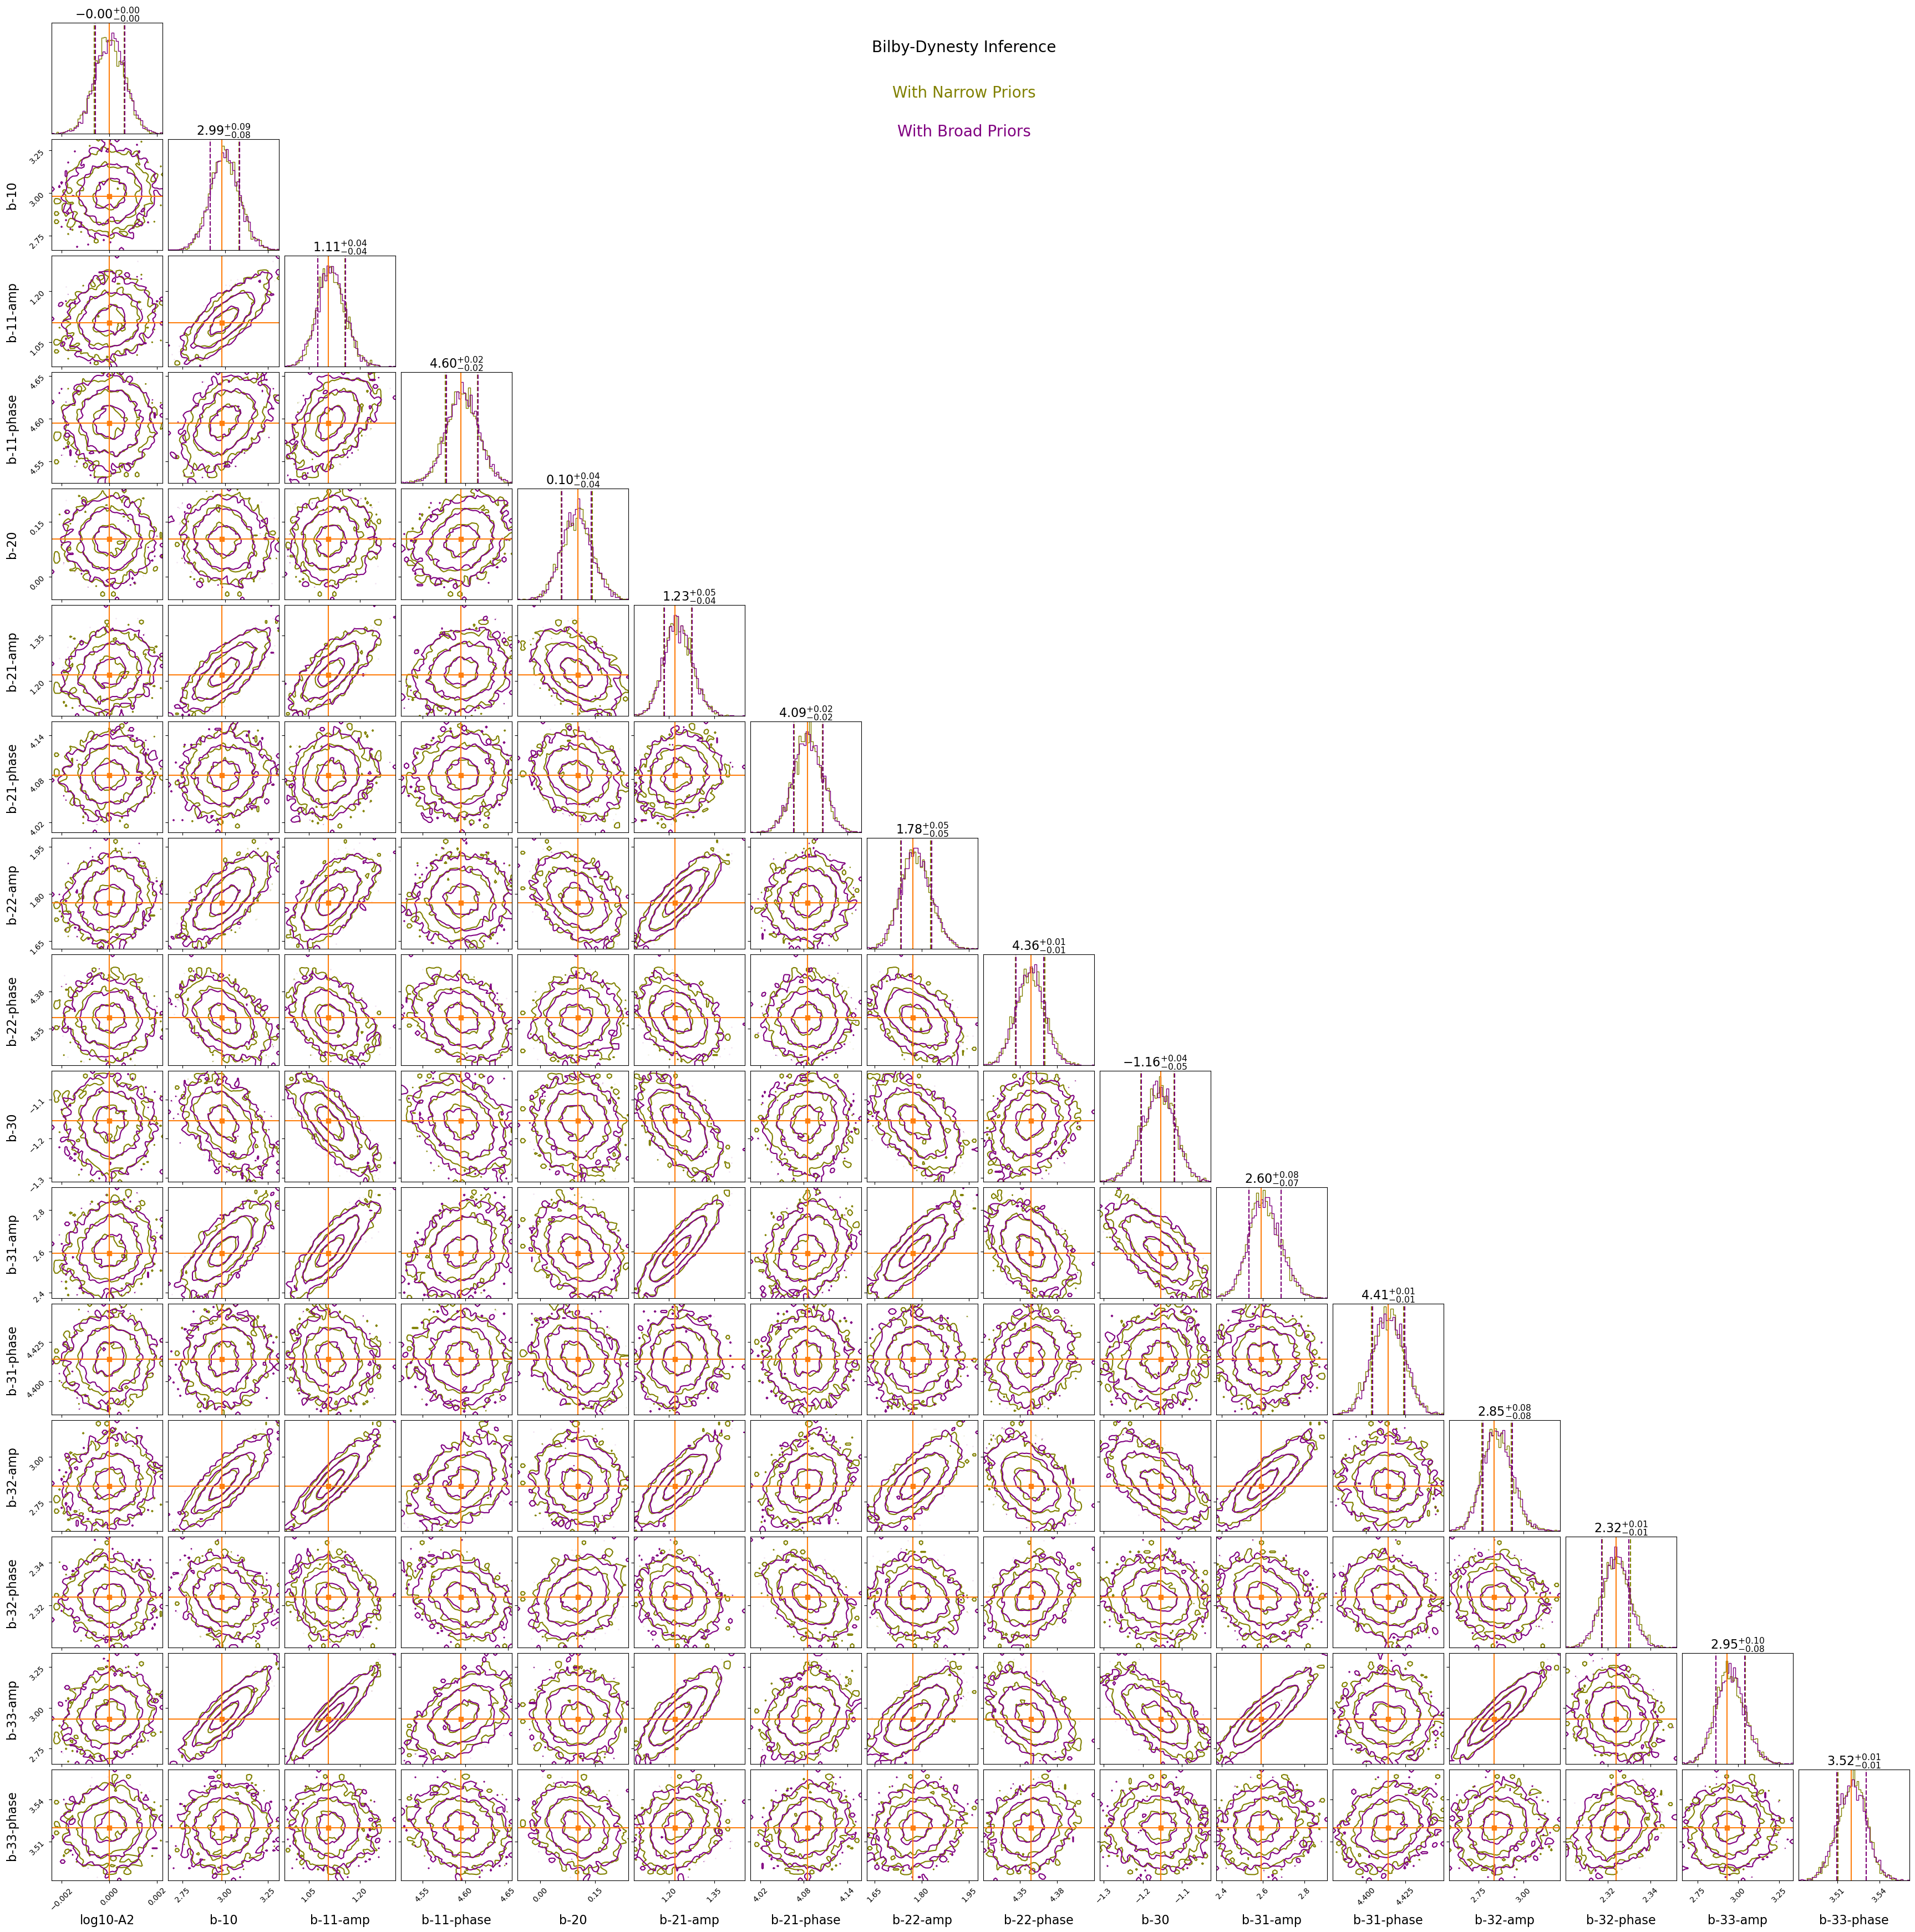

In [54]:
fig3 = result_narrow.plot_corner(parameters=result_narrow.parameter_labels, 
                                 plot_datapoints=True, fill_contours=False, plot_density=False,
                                 save=False, color='olive', title_quantiles=[0.16, 0.5, 0.84], 
                                 hist_kwargs=dict(density=True, histtype="step"))

result_broad.plot_corner(parameters={param:true for param, true in zip(result_broad.parameter_labels, [0.0, *pta_ptmcmc_broad.injected_blms[1:]])}, 
                         fig=fig3, plot_datapoints=True, fill_contours=False, plot_density=False,
                         save=False, color='purple', title_quantiles=[0.16, 0.5, 0.84], 
                         hist_kwargs=dict(density=True, histtype="step"))


fig3.suptitle('Bilby-Dynesty Inference', fontsize=20)
fig3.text(0.5, 0.95, "With Narrow Priors", color='olive', ha="center", fontsize=20)
fig3.text(0.5, 0.93, "With Broad Priors", color='purple', ha="center", fontsize=20)


plt.show()

#### Here we see that all the injected parameters are recovered with a nested sampler (Dynesty) with both narrow and broad prior cases as opposed to PTMCMC

#### 4. Recovered power-map, $C_{l}$ and ORF 

First, we need to obtain their samples using the $b_{lm}$ posterior samples. We use a handy funtion in utils to do so. ``` utils.posterior_sampled_skymap_Cl_orf(pta, data, n_draws) ``` return collection of power-maps, Cl, ORF randomly drawn from the given posteriors in ```data``` of shape ($N_{pars} \times N_{samples}$) where the number of draws are fixed by $n_{draws}$.

In [62]:
### For PTMCMC
rec_pow_map_ptmcmc_narrow, rec_Cl_ptmcmc_narrow, rec_orf_ptmcmc_narrow = \
utils.posterior_sampled_skymap_Cl_orf(pta_ptmcmc_narrow, data=ptmcmc_corner_params_narrow.T, n_draws=5000)

rec_pow_map_ptmcmc_broad, rec_Cl_ptmcmc_broad, rec_orf_ptmcmc_broad = \
utils.posterior_sampled_skymap_Cl_orf(pta_ptmcmc_broad, data=ptmcmc_corner_params_broad.T, n_draws=5000)

n_draw:   0%|                                                              | 0/5000 [00:00<?, ?it/s]/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/enterprise/signals/anis_coefficients.py:194: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  h = hp.alm2map(alm, nside, maxl, verbose=False)
n_draw: 100%|███████████████████████████████████████████████████| 5000/5000 [01:15<00:00, 66.07it/s]


In [66]:
### For Bilby-Dynesty
rec_pow_map_bb_narrow, rec_Cl_bb_narrow, rec_orf_bb_narrow = \
utils.posterior_sampled_skymap_Cl_orf(pta_bb_narrow, data=result_narrow.posterior.to_numpy().T, n_draws=3000)

rec_pow_map_bb_broad, rec_Cl_bb_broad, rec_orf_bb_broad = \
utils.posterior_sampled_skymap_Cl_orf(pta_bb_broad, data=result_broad.posterior.to_numpy().T, n_draws=3000)

n_draw:   0%|                                                              | 0/3000 [00:00<?, ?it/s]/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/enterprise/signals/anis_coefficients.py:194: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  h = hp.alm2map(alm, nside, maxl, verbose=False)
n_draw: 100%|███████████████████████████████████████████████████| 3000/3000 [00:47<00:00, 62.70it/s]


##### Now get the median of each and plot them

In [67]:
### Get the median of power-map, Cl and orf distribution

rec_pow_map_ptmcmc_narrow_med = [np.median(rec_pow_map_ptmcmc_narrow[:, i]) for i in range(pta_ptmcmc_narrow.npix)]
rec_Cl_ptmcmc_narrow_med = [np.median(rec_Cl_ptmcmc_narrow[:, i]) for i in range(pta_ptmcmc_narrow.l_max+1)]
rec_orf_ptmcmc_narrow_med = [np.median(rec_orf_ptmcmc_narrow[:, i]) for i in range(pta_ptmcmc_narrow.npairs)]

rec_pow_map_ptmcmc_broad_med = [np.median(rec_pow_map_ptmcmc_broad[:, i]) for i in range(pta_ptmcmc_broad.npix)]
rec_Cl_ptmcmc_broad_med = [np.median(rec_Cl_ptmcmc_broad[:, i]) for i in range(pta_ptmcmc_broad.l_max+1)]
rec_orf_ptmcmc_broad_med = [np.median(rec_orf_ptmcmc_broad[:, i]) for i in range(pta_ptmcmc_broad.npairs)]

rec_pow_map_bb_narrow_med = [np.median(rec_pow_map_bb_narrow[:, i]) for i in range(pta_bb_narrow.npix)]
rec_Cl_bb_narrow_med = [np.median(rec_Cl_bb_narrow[:, i]) for i in range(pta_bb_narrow.l_max+1)]
rec_orf_bb_narrow_med = [np.median(rec_orf_bb_narrow[:, i]) for i in range(pta_bb_narrow.npairs)]

rec_pow_map_bb_broad_med = [np.median(rec_pow_map_bb_broad[:, i]) for i in range(pta_bb_broad.npix)]
rec_Cl_bb_broad_med = [np.median(rec_Cl_bb_broad[:, i]) for i in range(pta_bb_broad.l_max+1)]
rec_orf_bb_broad_med = [np.median(rec_orf_bb_broad[:, i]) for i in range(pta_bb_broad.npairs)]

#### Recovered orf

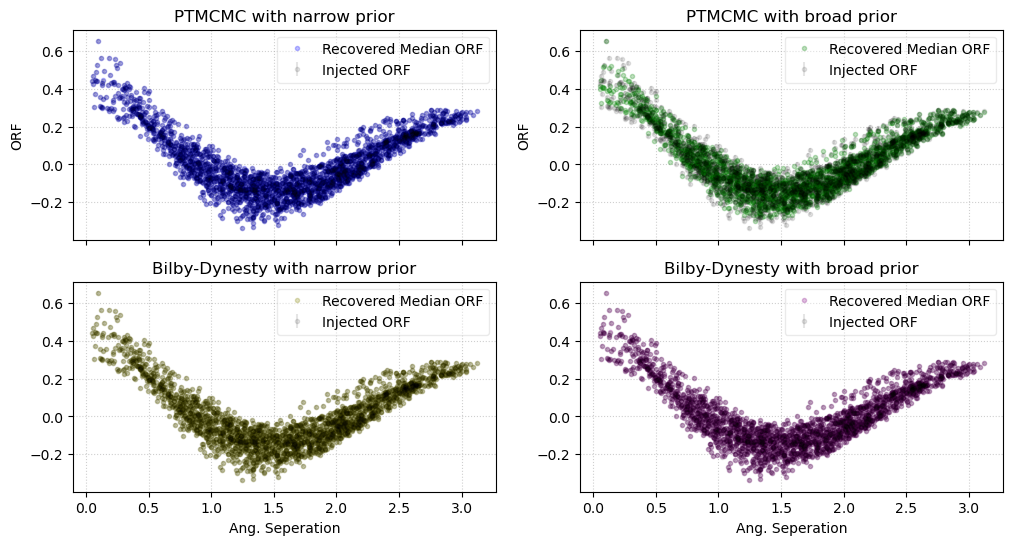

In [69]:
fig4, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True)


### Bilby ORF recovery
ax[0][0].errorbar(pta_ptmcmc_narrow.xi, pta_ptmcmc_narrow.injected_rho, pta_ptmcmc_narrow.injected_sig, 
                  ls='', color='black', marker='.', alpha=0.1, label='Injected ORF')
ax[0][0].plot(pta_ptmcmc_narrow.xi, rec_orf_ptmcmc_narrow_med, color='blue', ls='', marker='.', alpha=0.25, label='Recovered Median ORF')
ax[0][0].set_ylabel(r"ORF")
ax[0][0].legend(framealpha=0.4)
ax[0][0].grid(ls=':', alpha=0.6)
ax[0][0].set_title('PTMCMC with narrow prior')

ax[0][1].errorbar(pta_ptmcmc_broad.xi, pta_ptmcmc_broad.injected_rho, pta_ptmcmc_broad.injected_sig, 
                  ls='', color='black', marker='.', alpha=0.1, label='Injected ORF')
ax[0][1].plot(pta_ptmcmc_broad.xi, rec_orf_ptmcmc_broad_med, color='green', ls='', marker='.', alpha=0.25, label='Recovered Median ORF')
ax[0][1].set_ylabel(r"ORF")
ax[0][1].legend(framealpha=0.4)
ax[0][1].grid(ls=':', alpha=0.6)
ax[0][1].set_title('PTMCMC with broad prior')

ax[1][0].errorbar(pta_ptmcmc_narrow.xi, pta_ptmcmc_narrow.injected_rho, pta_ptmcmc_narrow.injected_sig, 
                  ls='', color='black', marker='.', alpha=0.1, label='Injected ORF')
ax[1][0].plot(pta_ptmcmc_narrow.xi, rec_orf_bb_narrow_med, color='olive', ls='', marker='.', alpha=0.25, label='Recovered Median ORF')
ax[1][0].set_xlabel(r"Ang. Seperation")
ax[1][0].legend(framealpha=0.4)
ax[1][0].grid(ls=':', alpha=0.6)
ax[1][0].set_title('Bilby-Dynesty with narrow prior')

ax[1][1].errorbar(pta_ptmcmc_broad.xi, pta_ptmcmc_broad.injected_rho, pta_ptmcmc_broad.injected_sig, 
                  ls='', color='black', marker='.', alpha=0.1, label='Injected ORF')
ax[1][1].plot(pta_ptmcmc_broad.xi, rec_orf_bb_broad_med, color='purple', ls='', marker='.', alpha=0.25, label='Recovered Median ORF')
ax[1][1].set_xlabel(r"Ang. Seperation")
ax[1][1].legend(framealpha=0.4)
ax[1][1].grid(ls=':', alpha=0.6)
ax[1][1].set_title('Bilby-Dynesty with broad prior')



plt.show()

#### Recovered $C_{l}$

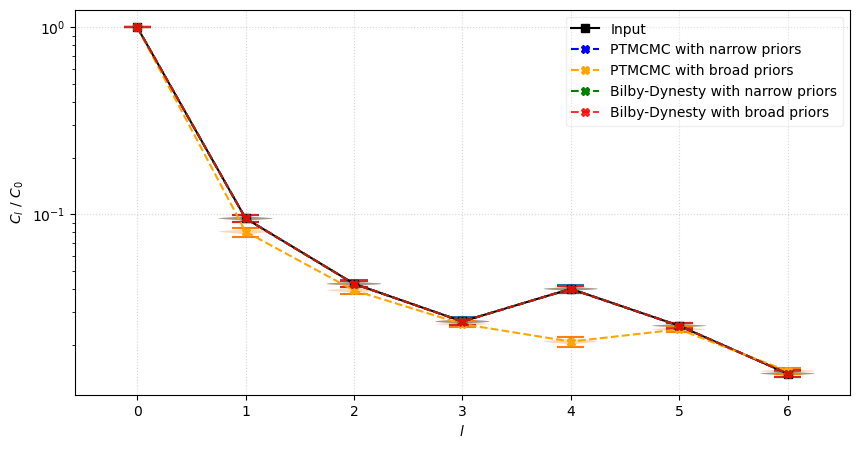

In [75]:
plt.figure(figsize=(10, 5))

plt.violinplot(rec_Cl_ptmcmc_narrow/rec_Cl_ptmcmc_narrow[0][0], positions=range(pta_ptmcmc_narrow.l_max+1), showextrema=True)
plt.violinplot(rec_Cl_ptmcmc_broad/rec_Cl_ptmcmc_broad[0][0], positions=range(pta_ptmcmc_broad.l_max+1), showextrema=True)

plt.violinplot(rec_Cl_bb_narrow/rec_Cl_bb_narrow[0][0], positions=range(pta_bb_narrow.l_max+1), showextrema=True)
plt.violinplot(rec_Cl_bb_broad/rec_Cl_bb_broad[0][0], positions=range(pta_bb_broad.l_max+1), showextrema=True)


plt.plot(range(pta_ptmcmc_narrow.l_max+1), pta_ptmcmc_narrow.injected_Cl/pta_ptmcmc_narrow.injected_Cl[0], 
         color='black', marker='s', label='Input')
plt.plot(range(pta_ptmcmc_narrow.l_max+1), rec_Cl_ptmcmc_narrow_med/rec_Cl_ptmcmc_narrow_med[0], 
         color='blue', ls ='--', marker='X', label='PTMCMC with narrow priors')
plt.plot(range(pta_ptmcmc_broad.l_max+1), rec_Cl_ptmcmc_broad_med/rec_Cl_ptmcmc_broad_med[0], 
         color='orange', ls ='--', marker='X', label='PTMCMC with broad priors')
plt.plot(range(pta_bb_narrow.l_max+1), rec_Cl_bb_narrow_med/rec_Cl_bb_narrow_med[0], 
         color='green', ls ='--', marker='X', label='Bilby-Dynesty with narrow priors')
plt.plot(range(pta_bb_broad.l_max+1), rec_Cl_bb_broad_med/rec_Cl_bb_broad_med[0], 
         color='red', ls ='--', marker='X', label='Bilby-Dynesty with broad priors', alpha=0.8)

plt.xlabel(r'$l$')
plt.ylabel(r'$C_{l} \ / \ C_{0}$')

plt.yscale('log')

plt.legend(framealpha=0.3)
plt.grid(ls=':', alpha=0.5)
plt.show()

#### Recovered power-map

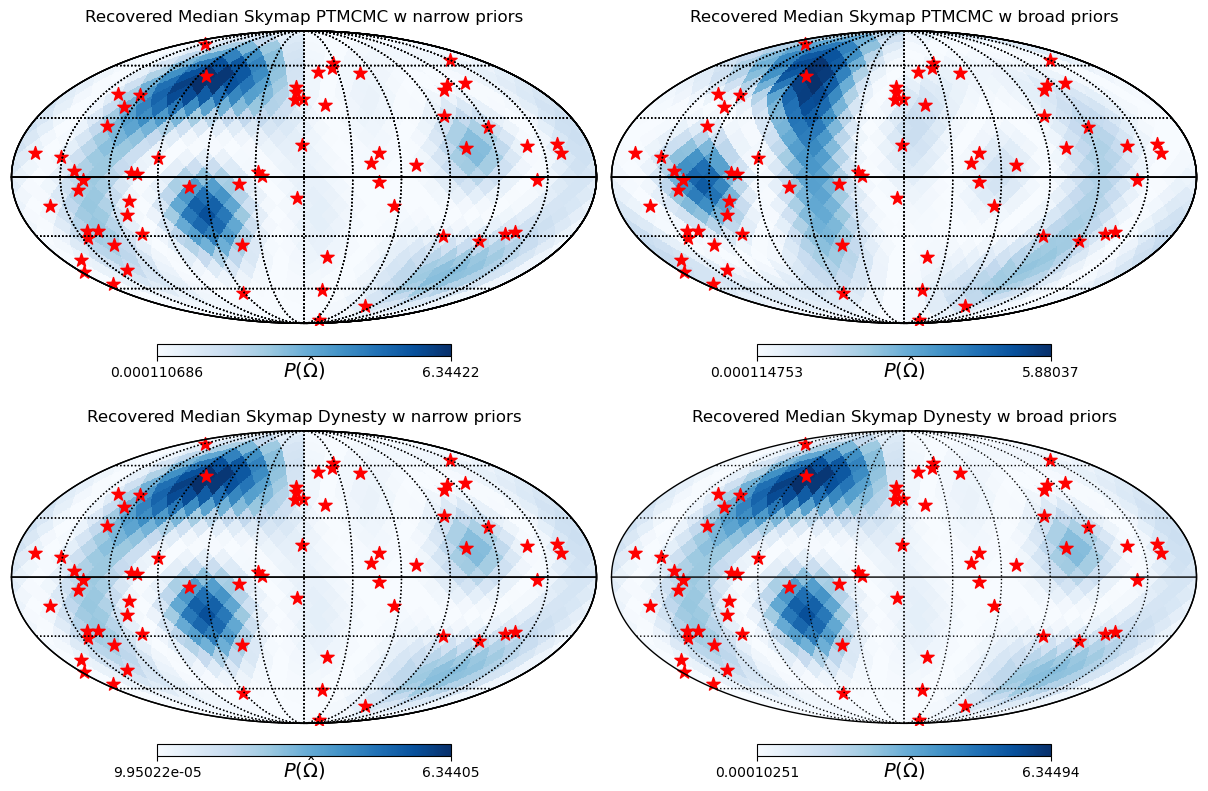

In [76]:
plt.figure(figsize=(12, 8))

hp.mollview(np.array(rec_pow_map_ptmcmc_narrow_med), sub=221, title = 'Recovered Median Skymap PTMCMC w narrow priors',cmap='Blues', 
            unit='$P(\hat\Omega)$', rot=180)
hp.graticule()

hp.mollview(np.array(rec_pow_map_ptmcmc_broad_med), sub=222, title = 'Recovered Median Skymap PTMCMC w broad priors',cmap='Blues', 
            unit='$P(\hat\Omega)$', rot=180)
hp.graticule()

hp.mollview(np.array(rec_pow_map_bb_narrow_med), sub=223, title = 'Recovered Median Skymap Dynesty w narrow priors',cmap='Blues', 
            unit='$P(\hat\Omega)$', rot=180)
hp.graticule()

hp.mollview(np.array(rec_pow_map_bb_broad_med), sub=224, title = 'Recovered Median Skymap Dynesty w broad priors',cmap='Blues', 
            unit='$P(\hat\Omega)$', rot=180)
hp.graticule()

hp.projscatter(pta_ptmcmc_narrow.psrs_theta, pta_ptmcmc_narrow.psrs_phi, color = 'red', marker = '*', s = 100)
plt.show()